# Figure 3

In [13]:
import sys
import pandas as pd
import numpy as np
import scipy.integrate
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
import sympy as sm
from tqdm import tqdm

# Import my own libraries
sys.path.append('./utils/')
from odeAnalysisUtils import rdModel_nsKill,Simulate_AT_FixedThreshold,\
                            GenerateATComparisonPlot,GenerateParameterDic,\
                            ProfileTreatmentStrategies

# Format plot
sns.set(style="white",
        font_scale=1.5,
        font="Serif",
        rc={'figure.figsize':(12,6)})

In [14]:
# Define the parameters
paramDic = {"rS":.027, "rR":.027, "cRS":1., "cSR":1.,"dD":1.5, 
            "k":1., "D":0, "theta":1, 'DMax':1.}
paramDic['dR'] = 0.2*paramDic['rR']
paramDic['dS'] = 0.2*paramDic['rS']
nTimePts = 100
dt = 1.
intervalLength = 1
rFracPalette = {0.001:sns.xkcd_rgb['coral'],0.01:sns.xkcd_rgb['scarlet'],0.1:sns.xkcd_rgb['dark red']}

# Make directory for figures
if not os.path.isdir("./figures/"):
    os.mkdir("./figures/")

## a) Example simulations for different values of $n_0$ and $f_R$

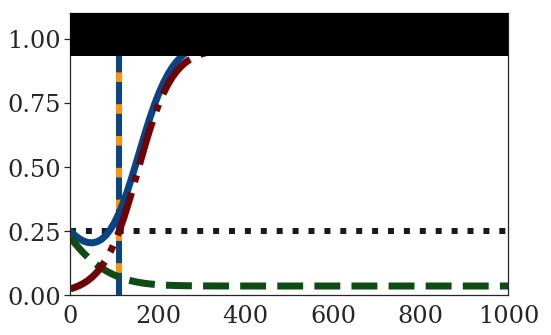

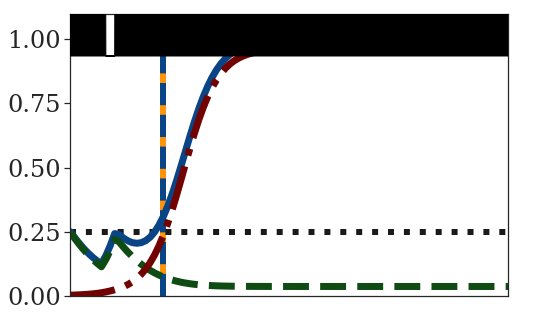

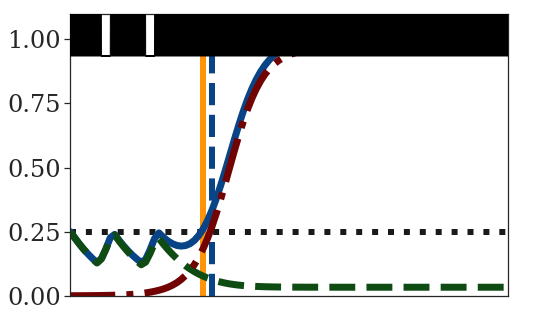

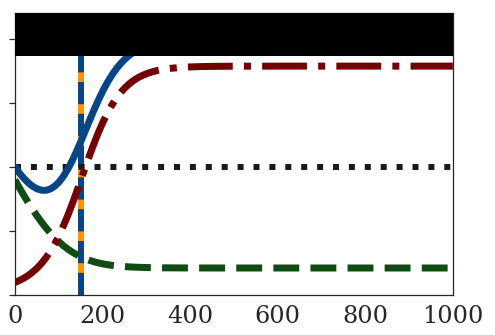

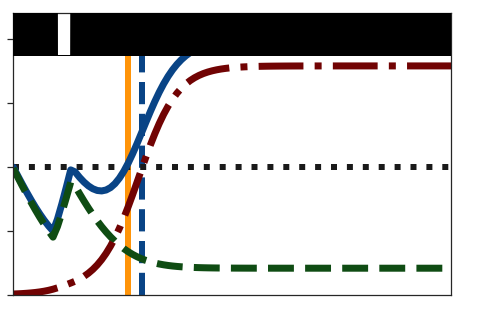

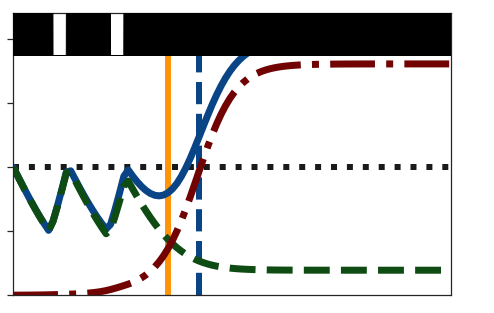

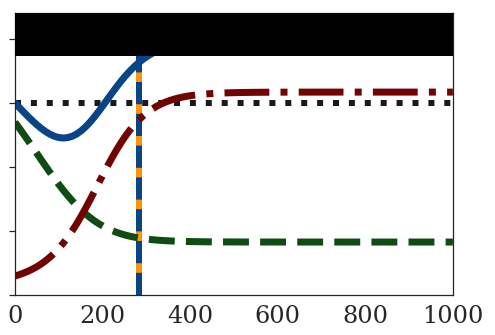

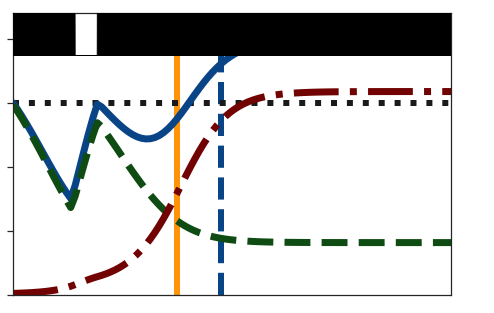

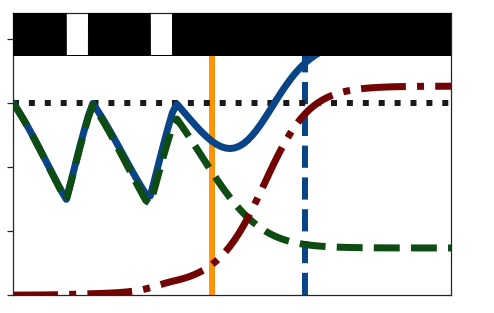

In [6]:
tEnd = 1000

for i,initialSize in enumerate([x for x in [0.25,0.5,.75]]):
    for j,rFrac in enumerate([0.1,0.01,0.001]):
        _,currParamDic = GenerateParameterDic(initialSize=0,rFrac=0,cost=0,turnover=0, # Note: initial composition has no meaning here as it's set within the GenerateATComparisonPlot() function
                                              paramDic=paramDic)
        GenerateATComparisonPlot(initialTumourSize=initialSize,rFrac=rFrac,
                                 paramDic=currParamDic,t_end=tEnd,
                                 decorateX=j==0,decorateY=i<1,ylim=1.1,
                                 outName="figures/timeSeriesPlot_noTurnover_noCost_iS_%1.2f_rFrac_%1.2f.pdf"%(initialSize,rFrac))

## b) Quantification of TTP as a function of $n_0$ and $f_R$

In [9]:
initialSizeList = np.linspace(0.25,0.75,6)
rFracList = [0.1, .01, .001]
cost = 0
turnover = 0

In [10]:
# Collect the TTP data
if False:
    _,currParamDic = GenerateParameterDic(initialSize=0,rFrac=0,cost=cost,
                                          turnover=turnover,paramDic=paramDic)
    txComparisonDf = ProfileTreatmentStrategies(modelFun=rdModel_nsKill,paramDic=currParamDic,
                                       enableProgressBar=True,
                                       atThresholdList=[0.5],
                                       intervalLength=intervalLength,dt=dt,
                                       initialSizeList=initialSizeList,
                                       rFracList=rFracList,
                                       tumourSizeWhenProgressed=1.2,cureThreshold=1e-7)
    txComparisonDf.to_csv("./data/ttpComparison/ttpComparison_n0fR.csv")

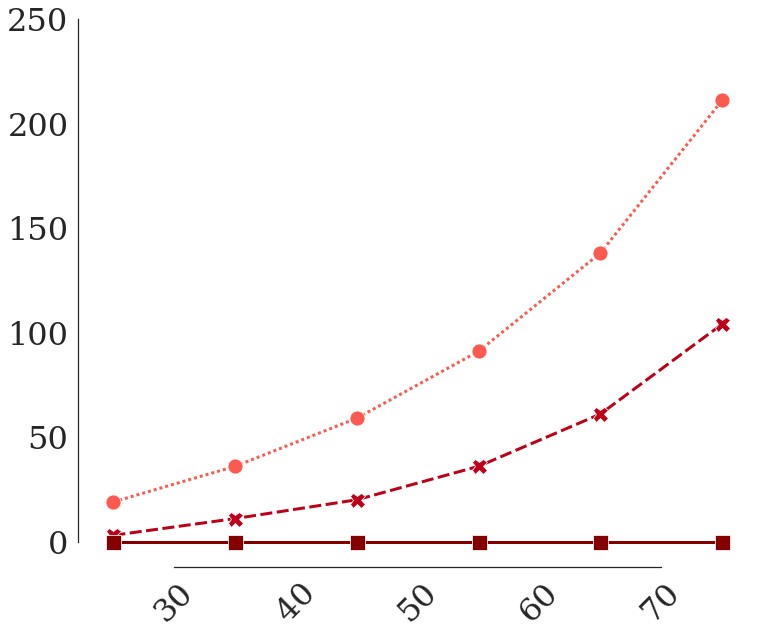

In [11]:
txComparisonDf = pd.read_csv("./data/ttpComparison/ttpComparison_n0fR.csv", index_col=0) #pd.read_csv("ttpComparison/ttpComparison_noCost_noDeath.csv")
txComparisonDf['InitialTumourSize'] *= 100

fig, ax = plt.subplots(1,1,figsize=(12,10))
sns.lineplot(x='InitialTumourSize',y='AbsTimeGained',
             style='RFrac',hue='RFrac',
             palette=rFracPalette,
             style_order={0.1,0.01,0.001},
             markers={0.001:'o',0.01:'X',0.1:'s'}, 
             lw=3, markersize=15,
             data=txComparisonDf,ax=ax)
ax.set_ylim(-10,250)
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(labelsize=32)
ax.get_legend().remove()
sns.despine(offset=5, trim=True)
plt.xticks(rotation=45);
plt.savefig("figures/ttpComparison_n0fR.pdf")

In [12]:
print(txComparisonDf.groupby("RFrac")['AbsTimeGained'].min())
print(txComparisonDf.groupby("RFrac")['AbsTimeGained'].max())

RFrac
0.001    19.0
0.010     3.0
0.100     0.0
Name: AbsTimeGained, dtype: float64
RFrac
0.001    211.0
0.010    104.0
0.100      0.0
Name: AbsTimeGained, dtype: float64


## c) Phase plane illustrating of how AT minimises dR/dt

### Phase plane code

In [15]:
from matplotlib.colors import Normalize
import sympy as sm
from matplotlib.colors import ListedColormap

def PlotRDotMap(fX,fY,varList,paramDic,plotTumourVolumeB=True,plotTumourGrowthRateB=False,
                   plotSGrowthRateB=False,plotRGrowthRateB=False,nLevels_overlay=None,
                   plotSteadyStates=True,solveNumerically=False,
                   xlimVec=[-0.01,1.5],ylimVec=[-0.01,1.5],nPoints=100,
                   figsize=(8,8),lw=5,
                   legendLoc='upper right',titleStr="",decorate=True,
                   arrowsize=1.2, density=[0.8, 2.], arrowLineWidth=1., vmax=0.25,
                   sizeWhenProgressed=None,
                   ax=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    sVec = np.linspace(max(xlimVec[0],0), xlimVec[1], nPoints)
    rVec = np.linspace(max(ylimVec[0],0), ylimVec[1], nPoints)

    # Plot the vector-field
    fX_lambidified = sm.lambdify(varList, fX)
    FlowFun_X = lambda s, r, paramDic: fX_lambidified(
        *tuple([{"s": s, "r": r, **paramDic}[str(var)] for var in varList]))
    fY_lambidified = sm.lambdify(varList, fY)
    FlowFun_Y = lambda s, r, paramDic: fY_lambidified(
        *tuple([{"s": s, "r": r, **paramDic}[str(var)] for var in varList]))
    X, Y = np.meshgrid(sVec, rVec)
    U = FlowFun_X(X, Y, paramDic)/paramDic['rS']
    V = FlowFun_Y(X, Y, paramDic)/paramDic['rS']
    if plotRGrowthRateB:  # Colour by dR/dt
        nLevels_overlay = 50 if nLevels_overlay is None else nLevels_overlay
        vMat = V
        norm = MidpointNormalize(midpoint=0,vmin=-0.05,vmax=vmax)
        vMat[vMat<0] = np.nan
        ax.contourf(X, Y, vMat, nLevels_overlay, cmap=ListedColormap(sns.color_palette("BrBG_r", nLevels_overlay)[::-1]), alpha=0.8, norm=norm)
        #         ax.colorbar();
        contours = ax.contour(X, Y, vMat, 6, colors='black');
        ax.clabel(contours, inline=True, fontsize=14)

#     ax.streamplot(X, Y, U, V, color='k', linewidth=arrowLineWidth, density=density, arrowsize=arrowsize)

    # Plot the null-clines
    s, r, cRS, cSR, p, d, D = sm.symbols('s, r, cRS, cSR, p, d, D', negative=False)
    nc_SExpr = sm.solve(sm.Eq(fX,0),r)[0]
    nc_RExpr = sm.solve(sm.Eq(fY,0),r)[1]
    nc_S = lambda sValVec: [nc_SExpr.subs([(s,sVal)]+[(var,paramDic[str(var)]) for var in varList if str(var) not in ["s","r"]]) for sVal in sValVec]
    nc_R = lambda sValVec: [nc_RExpr.subs([(s,sVal)]+[(var,paramDic[str(var)]) for var in varList if str(var) not in ["s","r"]]) for sVal in sValVec]
    # s-nullclines
#     ax.plot(sVec,nc_S(sVec),lw=lw,color="#107920",label=r'$\dot{s}=0$') #sns.xkcd_rgb['bluegreen']
#     ax.plot(np.zeros_like(rVec),rVec,lw=lw,color="#107920") #sns.xkcd_rgb['bluegreen']
    # r-nullclines
    ax.plot(sVec,nc_R(sVec),lw=lw,color="#BA120A",label=r'$\dot{r}=0$',
            linestyle='-' if np.all(np.abs(np.array(nc_R(sVec))-np.array(nc_S(sVec)))<1e-5) else '-') #
#     ax.plot(sVec,np.zeros_like(sVec),lw=lw,color="#BA120A")
    # Add progression line
    if sizeWhenProgressed is not None:
        progressionLineFun = lambda x: sizeWhenProgressed-x
        ax.plot(sVec,progressionLineFun(sVec),lw=lw,color="#5F5F5F",
                linestyle='--') #


    # Plot the equilibrium points
    if plotSteadyStates:
        if solveNumerically:
            # Divide region under consideration into a 25x25 grid and solve for the
            # steady states numerically in this region
            startSSSearchFromHereList = [(x,y) for x in np.linspace(xlimVec[0],xlimVec[1],25)
                                     for y in np.linspace(ylimVec[0],ylimVec[1],25)]
            ssDic = {} # Dictionary to record unique steady states
            for point in startSSSearchFromHereList:
                try:
                    ss = sm.nsolve((fX.subs([(var,paramDic[str(var)]) for var in varList if str(var) not in ["s","r"]]),
                               fY.subs([(var,paramDic[str(var)]) for var in varList if str(var) not in ["s","r"]])),
                              (s,r),point)
                    ss = [np.round(float(x),2) for x in ss]
                    if ssDic.get(ss[0],True) is True:
                        ssDic[ss[0]] = ss[1]
                except:
                    pass
            equilibriaList = [(key,ssDic[key]) for key in ssDic.keys()]
        else:
            equilibriaList = sm.solve( (sm.Eq(fX, 0), sm.Eq(fY, 0)), s, r )
            equilibriaList = [equilibriaList[k] for k in range(len(equilibriaList))]#[0,1,3,2]]
        J = sm.Matrix([fX,fY])
        J = J.jacobian([s,r])
        for ss in equilibriaList:
            # Find ss
            if solveNumerically:
                sstar,rstar = ss
            else:
                sstar = ss[0].subs([(var,paramDic[str(var)]) for var in varList if str(var) not in ["s","r"]])
                rstar = ss[1].subs([(var,paramDic[str(var)]) for var in varList if str(var) not in ["s","r"]])
            # Determine stability
            localJ = J.subs([(s,ss[0]), (r,ss[1])]+[(var,paramDic[str(var)]) for var in varList if str(var) not in ["s","r"]])
            stableB = np.all([sm.re(k)<0 for k in localJ.eigenvals().keys()])
            # Plot
            if solveNumerically is False and (sstar.has('oo', '-oo', 'zoo', 'nan') or sstar.has('oo', '-oo', 'zoo', 'nan')):
                print("Warning: A steady state is complex and was not plotted")
                continue
            ax.plot(sstar,rstar,linestyle='none',marker="o",
                    markersize=30, markeredgecolor='black',
                    color=sns.xkcd_rgb['khaki green' if stableB else 'burnt red'])

    # Decorate
    ax.set_xlim(xlimVec)
    ax.set_ylim(ylimVec)
    ax.set_xlabel(r"$s$" if decorate else "")
    ax.set_ylabel(r"$s$" if decorate else "")
    ax.set_title(titleStr)
    if legendLoc!='off': ax.legend(loc=legendLoc)

    return ax

# --------------------------- Miscellaneous -----------------------------------------------------
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [16]:
def RunSimulations(initialTumourSize,sFrac,paramDic=paramDic,
                             t_end=1500,relToPopEq=False,finishAtProgression=True,
                             intervalLength=1.,nTimePts=100.):
    if relToPopEq: initialTumourSize *= (1-paramDic['dS']/paramDic['rS'])
    initialStateVec = [initialTumourSize*sFrac,initialTumourSize*(1-sFrac),0,paramDic['DMax']]
    initialStateVec[2] = paramDic['theta']*(initialStateVec[0] + initialStateVec[1])

    # Simulate
    resultsDf = Simulate_AT_FixedThreshold(modelFun=rdModel_nsKill,
                                           initialStateVec=initialStateVec,
                                           atThreshold=1.,intervalLength=t_end,
                                           paramDic=paramDic,
                                           t_end=t_end, t_eval=np.linspace(0,t_end,int(nTimePts)))
    ttp_ct = resultsDf.Time[resultsDf.V > 1.2*initialTumourSize].min()
    if finishAtProgression: 
        resultsDf_ct = resultsDf[resultsDf.Time<ttp_ct] if ttp_ct is not np.nan else resultsDf.copy()
    else:
        resultsDf_ct = resultsDf.copy()

    resultsDf = Simulate_AT_FixedThreshold(modelFun=rdModel_nsKill,
                                           initialStateVec=initialStateVec,
                                           atThreshold=.5,intervalLength=intervalLength,
                                           paramDic=paramDic,
                                           t_end=t_end, t_eval=np.linspace(0,t_end,int(nTimePts)))
    ttp_at = resultsDf.Time[resultsDf.V > 1.2*initialTumourSize].min()
    if finishAtProgression: 
        resultsDf_at = resultsDf[resultsDf.Time<ttp_at] if ttp_at is not np.nan else resultsDf.copy()
    else:
        resultsDf_at = resultsDf.copy()
    return (resultsDf_ct,resultsDf_at)

### Plot

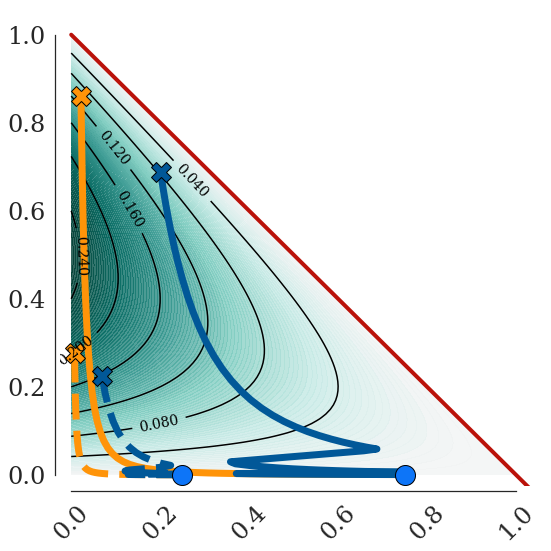

In [13]:
currParamDic = paramDic.copy()
currParamDic['dR'] = 0.
currParamDic['dS'] = 0.
tEnd = 1000

# Define equations using sympy
varList = sm.symbols('s, r, rS, rR, cRS, cSR, dS, dR, k, dD, D', negative=False)
s, r, rS, rR, cRS, cSR, dS, dR, k, dD, D = varList
fS = rS*(1-s-cRS*r)*(1-dD*D)*s-dS*s
fR = (rR-dR-rR/k*(cSR*s+r))*r


# Plot
fig, axList = plt.subplots(1,1,sharex=True,sharey=True,figsize=(8,8))
currAx = axList
currParamDic['D'] = currParamDic['DMax']
PlotRDotMap(fS,fR,varList,currParamDic,plotSteadyStates=False,
               ax=currAx,xlimVec=[-0.025,1.05],ylimVec=[-0.025,1.05],
               plotTumourGrowthRateB=False,plotTumourVolumeB=False,plotRGrowthRateB=True,
               decorate=False,nLevels_overlay=100,nPoints=100,
               titleStr="",legendLoc='off',arrowsize=1.5,arrowLineWidth=2.,lw=4)

# ------------------------------------------------------------------------
# Plot the simulations
for initialSize in [0.75,0.25]:
    simulationResultsDf = RunSimulations(initialTumourSize=initialSize,sFrac=0.999,paramDic=currParamDic,
                                     relToPopEq=False,t_end=tEnd)
    for treatmentId in range(2):
        col = '#FF9409' if treatmentId==0 else '#015898'
        currAx.plot(simulationResultsDf[treatmentId].S,simulationResultsDf[treatmentId].R,lw=7,
                    color=col,linestyle='-' if initialSize==0.75 else '--')

        # Add the end points
        currAx.plot(simulationResultsDf[treatmentId].S.iloc[-1],simulationResultsDf[treatmentId].R.iloc[-1],linestyle='none',marker="X",
            markersize=20, markeredgecolor='black',markeredgewidth=1,
            color=col)

    currAx.plot(simulationResultsDf[treatmentId].S.iloc[0],simulationResultsDf[treatmentId].R.iloc[0],
                linestyle='none',marker="o",
                markersize=20, markeredgecolor='black',
                color=sns.xkcd_rgb['deep sky blue'])

currAx.tick_params(labelsize=24)
sns.despine(offset=5, trim=True)
plt.xticks(rotation=45);
plt.tight_layout()
fig.savefig("figures/phasePlane_atDynamics.pdf")